# Imports

In [38]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from tqdm import tqdm
from skimage.transform import resize
import seaborn as sn
import pandas as pd

# Loading Datasets

In [39]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Preprocess and Save

### Load Preporcessed Dataset

39936


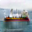

In [41]:
# loading images
images_l = load_obj_real("/work/kabaeuer/log/example/images_final/order_list")
print(len(images_l))
Image.fromarray(images_l[0])

In [42]:
images_l_rotated = []
for img in images_l:
    img = Image.fromarray(img)
    images_l_rotated.append(img.rotate(90))

39936


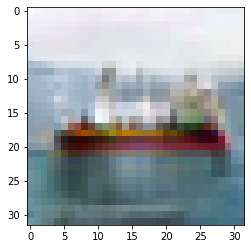

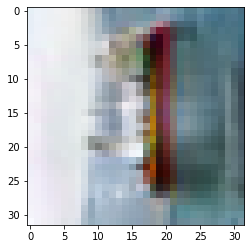

In [43]:
# Example image
print(len(images_l))
imgplot = plt.imshow(images_l[0])
plt.show()
imgplot = plt.imshow(images_l_rotated[0])
plt.show()

## Real Images

In [49]:
images_real = load_obj_real("/work/kabaeuer/data/cifar_order_list")

In [50]:
images_real_nette = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageNette/imagenette_images")
images_real_woof = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageWoof/imagewoof_images")
images_real_ffhq = load_obj_real("ffhq_64_64")

In [8]:
#import os
#import imageio
#path = "/work/kabaeuer/data/cifar_order_/cifar_order"
#i=0
#list_dir=[int(file.split(".")[0]) for file in os.listdir(path)]
#list_dir.sort()
#images_real = []
#for fname in list_dir:    
#    img = imageio.imread(path + '/' + str(fname)+".png")
#    images_real.append(img)
#save_obj(images_real,'/work/kabaeuer/data/cifar_order_list')

49993


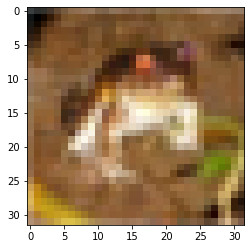

In [9]:
# Example image
print(len(images_real))
imgplot = plt.imshow(images_real[0])
plt.show()

In [10]:
images_real_rotated = []
for img in images_real:
    img = Image.fromarray(img)
    images_real_rotated.append(img.rotate(90))

# Analyzing Images

## Creating FFT

In [11]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

In [12]:
# Create Informations
def create_informations(images, normalized= False):
    two_dim = fft(images[0])
    if normalized:
        two_dim = two_dim /two_dim.max()
    m,n = two_dim.shape
    zero_axis = np.sum(two_dim, axis=0)/m
    one_axis = np.sum(two_dim, axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals /fft_vals.max()
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(two_dim, axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(two_dim, axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals/fft_vals.max()
        std_zero_axis = std_zero_axis + ((np.sum(fft_vals, axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft_vals, axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

### Generated Images

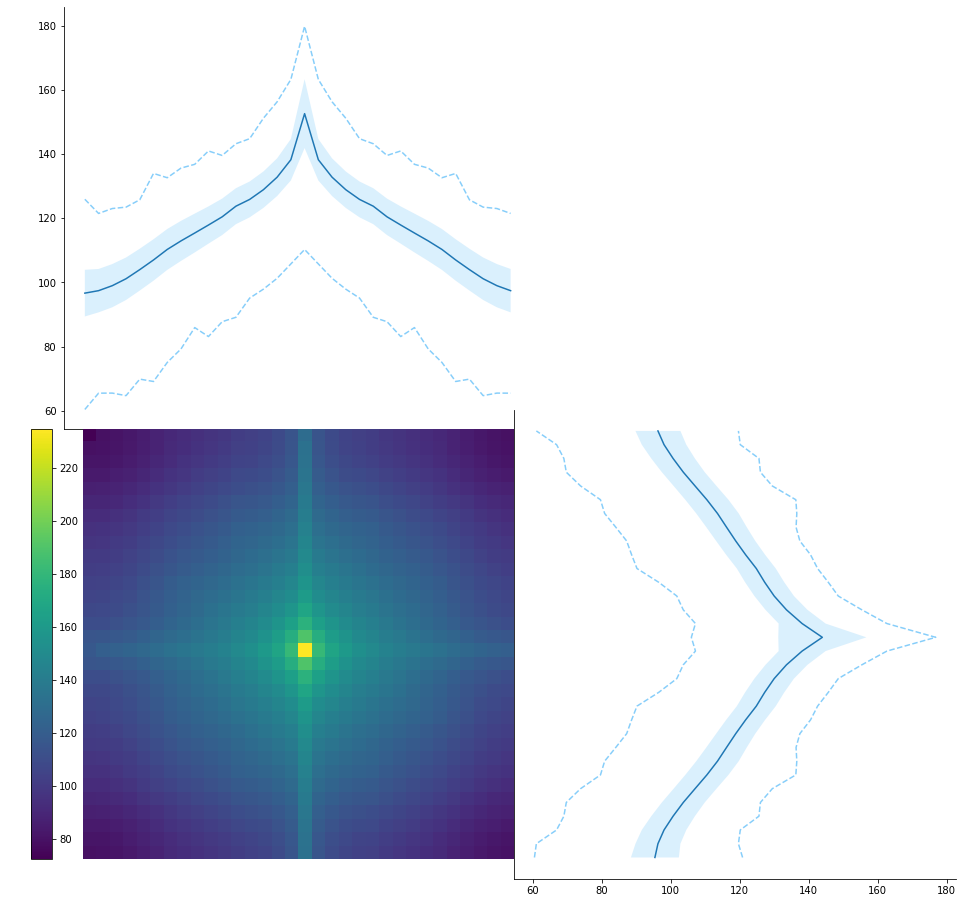

In [13]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g)

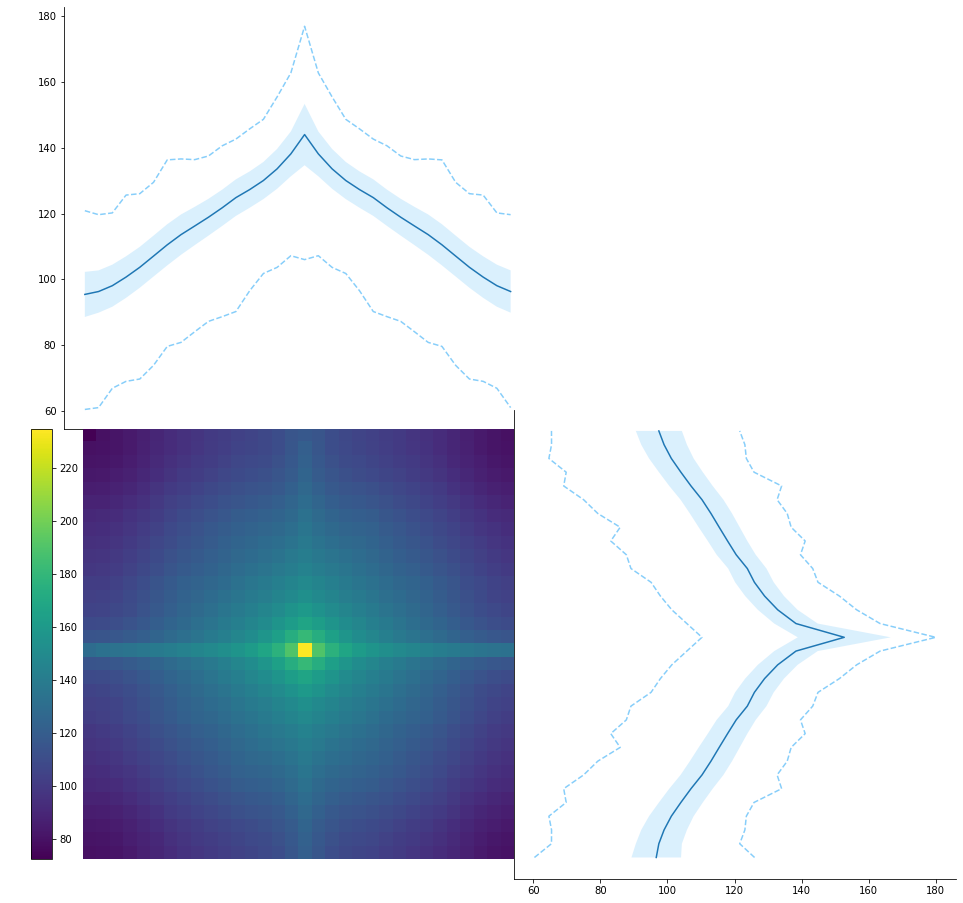

In [14]:
two_dim_g_r, zero_axis_g_r, one_axis_g_r, m_g_r, n_g_r,min_zero_axis_g_r,max_zero_axis_g_r, min_one_axis_g_r, max_one_axis_g_r, std_zero_axis_g_r, std_one_axis_g_r = create_informations(images_l_rotated)
create_overview_plot(two_dim_g_r, zero_axis_g_r, one_axis_g_r, m_g_r, n_g_r,min_zero_axis_g_r,max_zero_axis_g_r, min_one_axis_g_r, max_one_axis_g_r, std_zero_axis_g_r, std_one_axis_g_r)

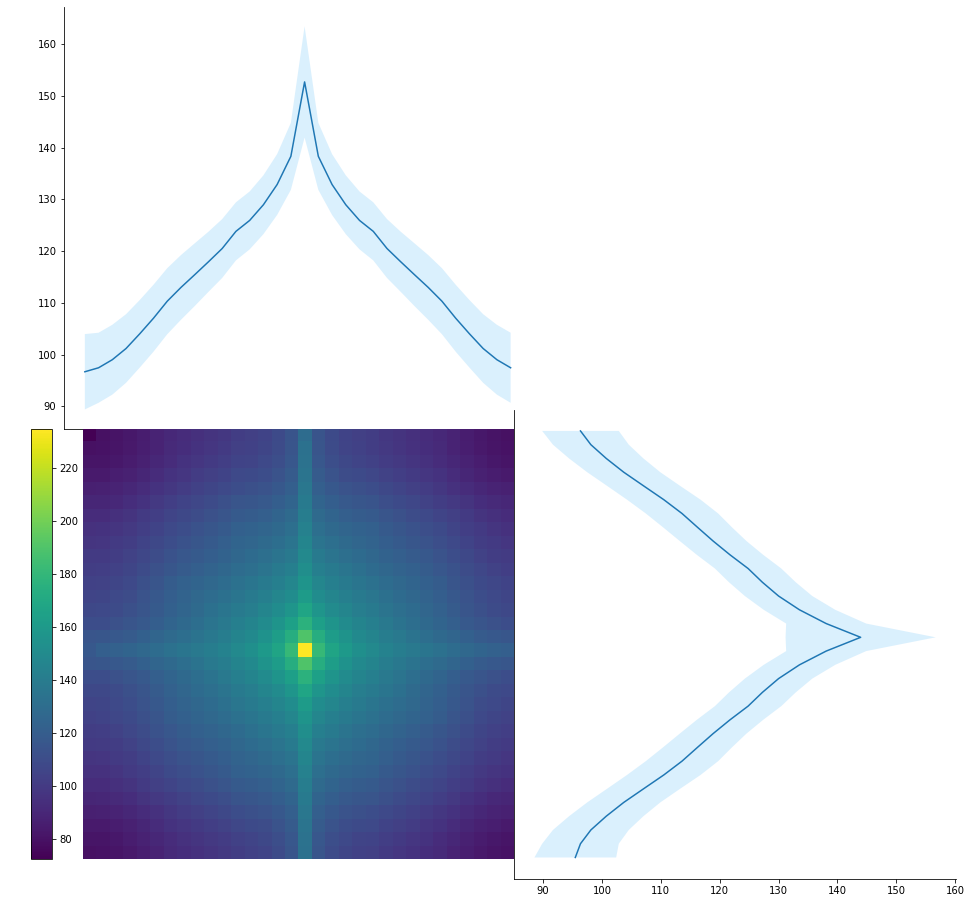

In [15]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = False)

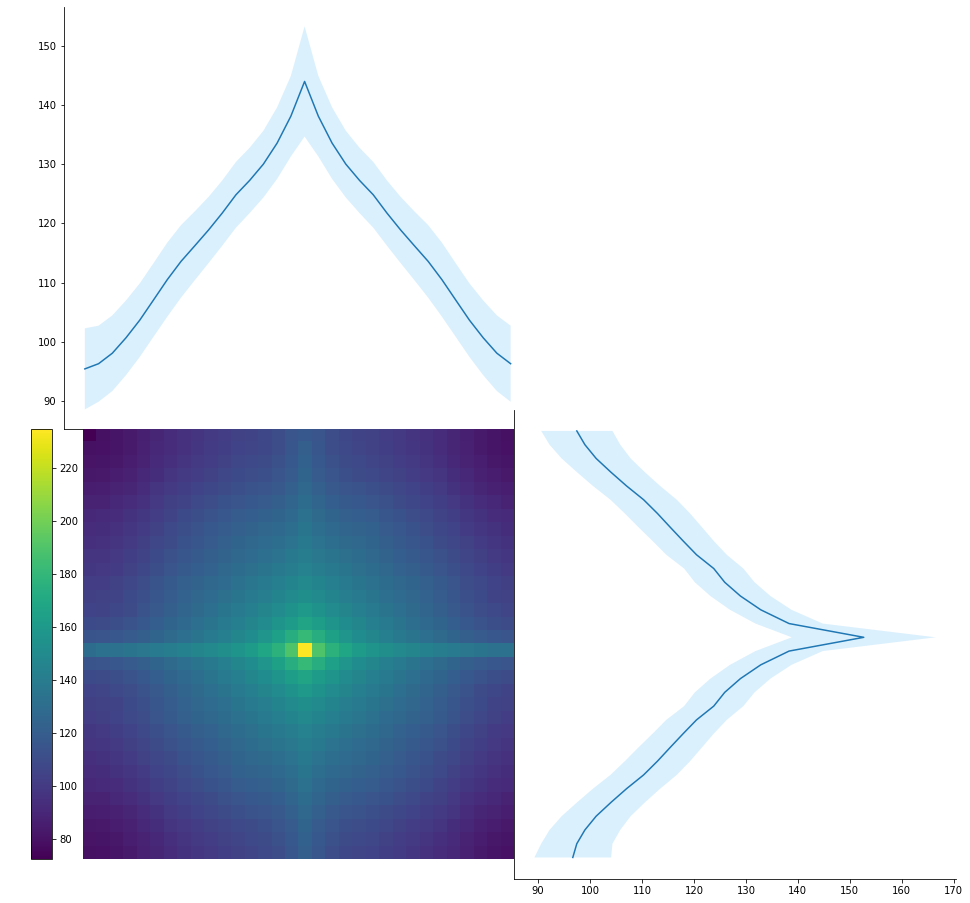

In [16]:
create_overview_plot(two_dim_g_r, zero_axis_g_r, one_axis_g_r, m_g_r, n_g,min_zero_axis_g_r,max_zero_axis_g_r, min_one_axis_g_r, max_one_axis_g_r, std_zero_axis_g_r, std_one_axis_g_r, max_min = False)

### Real Images

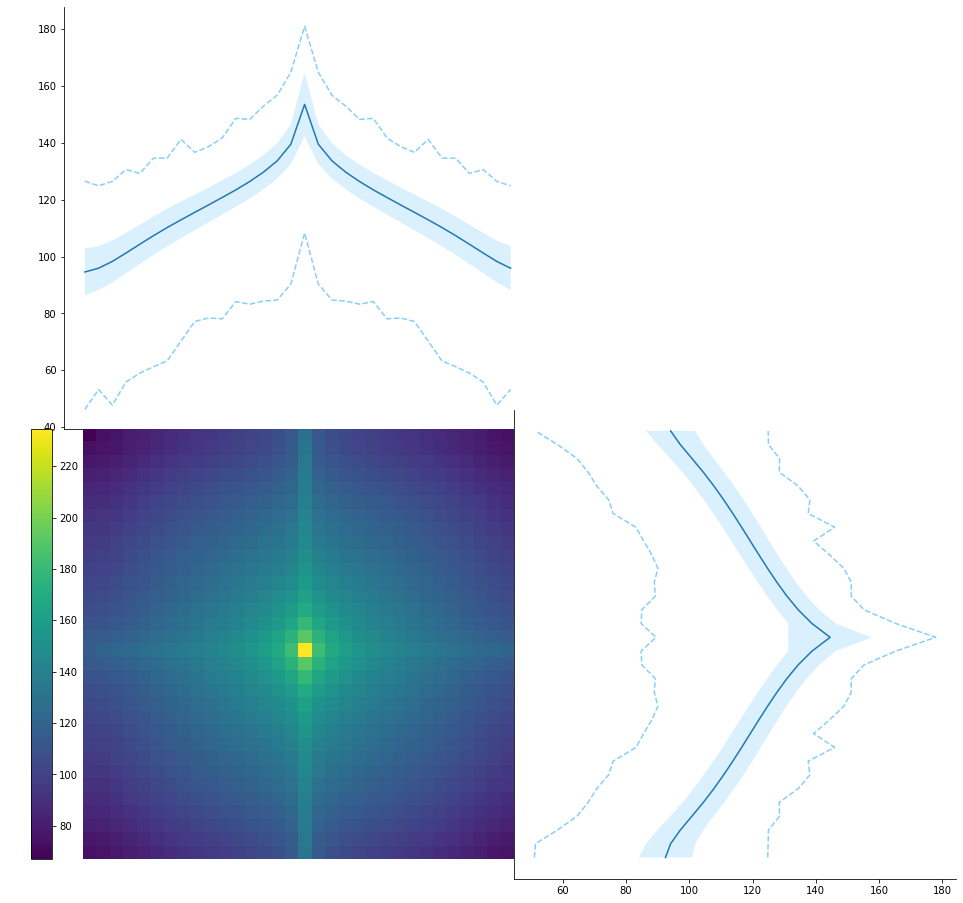

In [17]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = True)

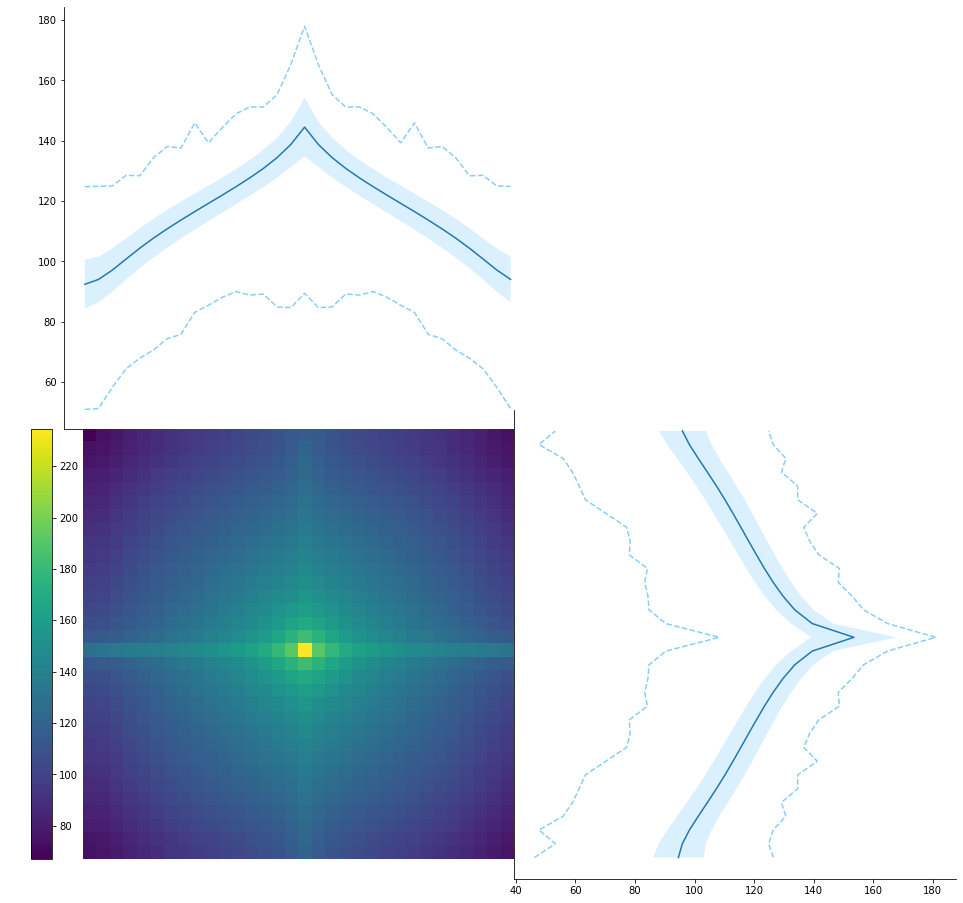

In [18]:
two_dim_r_r, zero_axis_r_r, one_axis_r_r, m_r_r, n_r_r,min_zero_axis_r_r,max_zero_axis_r_r, min_one_axis_r_r, max_one_axis_r_r, std_zero_axis_r_r, std_one_axis_r_r = create_informations(images_real_rotated)
create_overview_plot(two_dim_r_r, zero_axis_r_r, one_axis_r_r, m_r_r, n_r_r,min_zero_axis_r_r,max_zero_axis_r_r, min_one_axis_r_r, max_one_axis_r_r, std_zero_axis_r_r, std_one_axis_r_r, max_min = True)

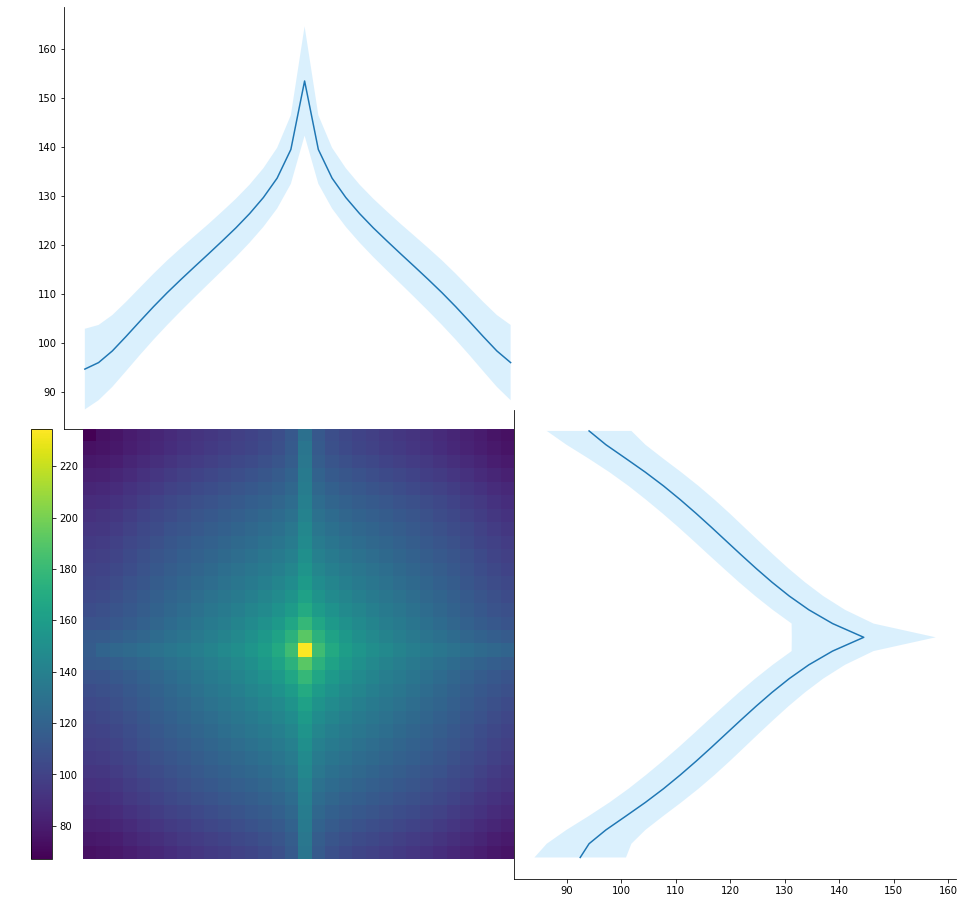

In [19]:
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = False)

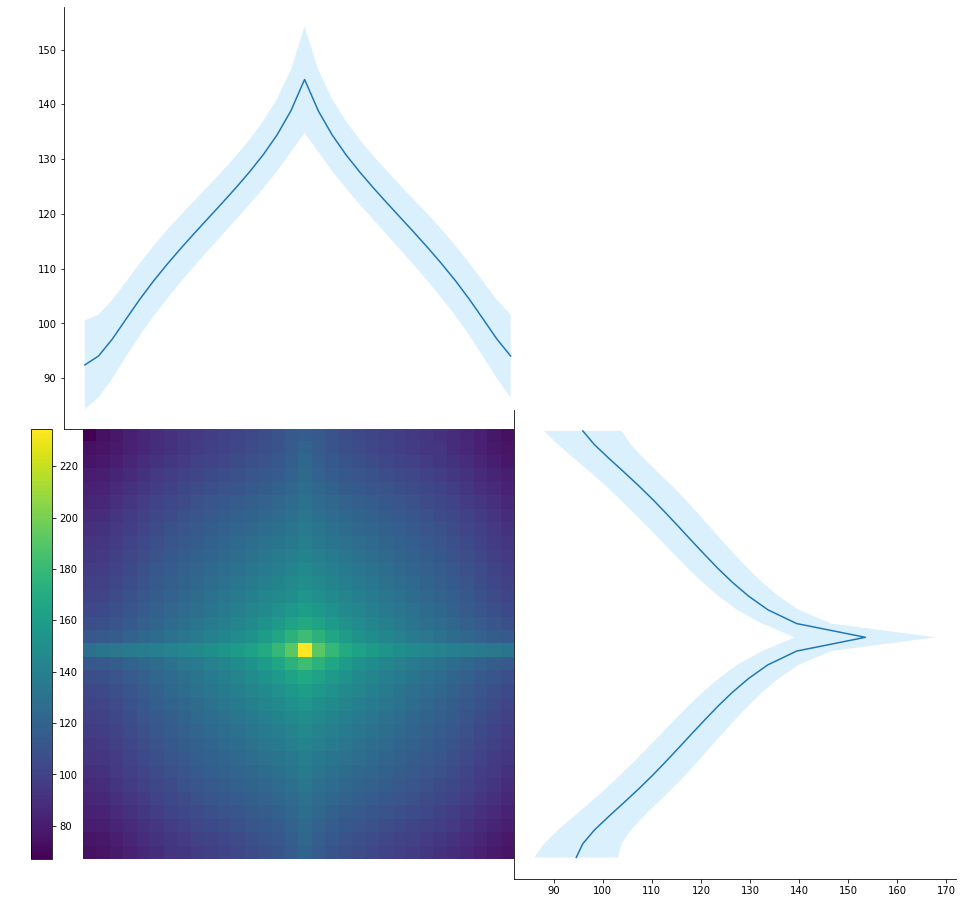

In [20]:
create_overview_plot(two_dim_r_r, zero_axis_r_r, one_axis_r_r, m_r_r, n_r_r,min_zero_axis_r_r,max_zero_axis_r_r, min_one_axis_r_r, max_one_axis_r_r, std_zero_axis_r_r, std_one_axis_r_r, max_min = False)

In [53]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
two_dim_t, zero_axis_t, one_axis_t, m_t, n_t,min_zero_axis_t,max_zero_axis_t, min_one_axis_t, max_one_axis_t, std_zero_axis_t, std_one_axis_t = create_informations(images_real_nette)
two_dim_t_b, zero_axis_t_b, one_axis_t_b, m_t_b, n_t_b, min_zero_axis_t_b, max_zero_axis_t_b, min_one_axis_t_b, max_one_axis_t_b, std_zero_axis_t_b, std_one_axis_t_b = create_informations(images_real_woof)
two_dim_t_bic, zero_axis_t_bic, one_axis_t_bic, m_t_bic, n_t_bic, min_zero_axis_t_bic, max_zero_axis_t_bic, min_one_axis_t_bic, max_one_axis_t_bic, std_zero_axis_t_bic, std_one_axis_t_bic = create_informations(images_real_ffhq)


In [59]:
len(list(zero_axis_t_bic/zero_axis_t_bic.max())[16:48])

33

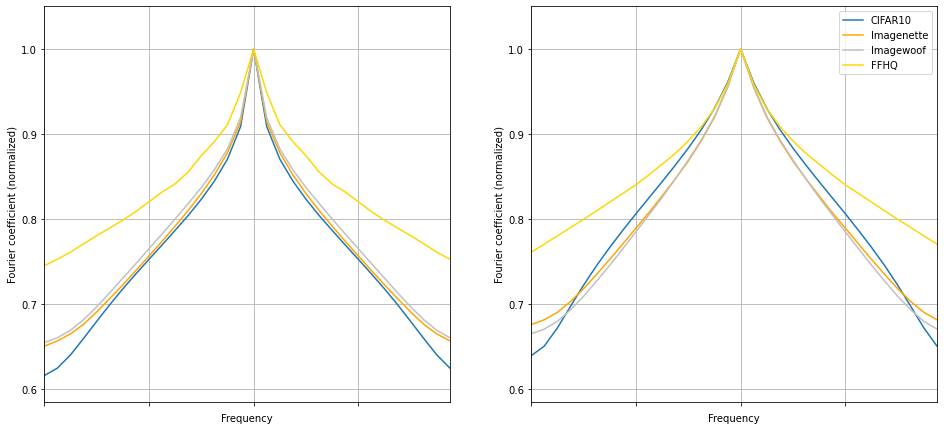

In [61]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='CIFAR10')
ax1.plot(range(len(zero_axis_t)),zero_axis_t/zero_axis_t.max(), label='Imagenette', color="orange")
ax1.plot(range(len(zero_axis_t_b)),zero_axis_t_b/zero_axis_t_b.max(), label='Imagewoof', color="silver")
ax1.plot(range(len(zero_axis_t_b)),list(zero_axis_t_bic/zero_axis_t_bic.max())[16:48], label='FFHQ', color="gold")


ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='CIFAR10')
ax2.plot(range(len(one_axis_t)),one_axis_t/one_axis_t.max(), label='Imagenette', color="orange")
ax2.plot(range(len(one_axis_t_b)),one_axis_t_b/one_axis_t_b.max(), label='Imagewoof', color="silver")
ax2.plot(range(len(zero_axis_t_b)),list(one_axis_t_bic/one_axis_t_bic.max())[16:48], label='FFHQ', color="gold")


ax1.grid()
ax2.grid()
ymin = min(min(zero_axis_r/zero_axis_r.max()),min(zero_axis_t/zero_axis_t.max()),min(one_axis_r/one_axis_r.max()),min(one_axis_t/one_axis_t.max()))
ymax = 1
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax2.set_xlabel('Frequency')
ax1.set_xticklabels([])
ax2.set_xticklabels([])

#leg = ax1.legend()
leg = ax2.legend()
#fig.suptitle("Comparison between Real, TransGAN (upsampling) - Normalized - left: colomn wise right: row-wise", fontsize=20)

### Transposed

Text(0.5, 0.98, 'Comparison between Real and Real_transposed ')

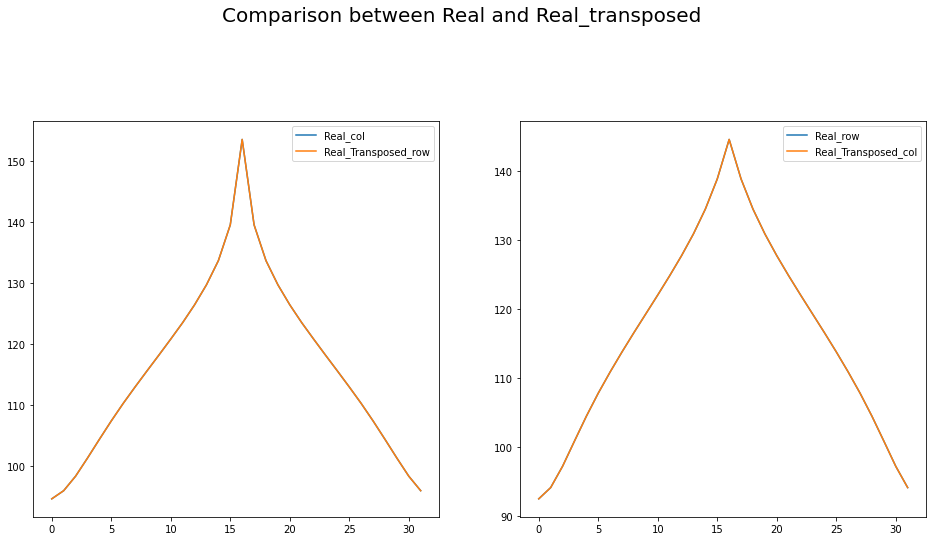

In [21]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real_col')
ax1.plot(range(len(zero_axis_r_r)),one_axis_r_r, label='Real_Transposed_row')
ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real_row')
ax2.plot(range(len(zero_axis_r_r)),zero_axis_r_r, label='Real_Transposed_col')
leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real and Real_transposed ", fontsize=20)

# Classes

## Generated

In [22]:
# loading images
list_classified = load_obj_real("log/example/images_final/classified")

In [23]:
subclass_0 = []
subclass_1 = []
subclass_2 = []
subclass_3 = []
subclass_4 = []
subclass_5 = []
subclass_6 = []
subclass_7 = []
subclass_8 = []
subclass_9 = []

# create subclasses
for i in range(0,len(images_l)):
    if list_classified[i] == 0:
        subclass_0.append(images_l[i])
    if list_classified[i] == 1:
        subclass_1.append(images_l[i])
    if list_classified[i] == 2:
        subclass_2.append(images_l[i])
    if list_classified[i] == 3:
        subclass_3.append(images_l[i])
    if list_classified[i] == 4:
        subclass_4.append(images_l[i])
    if list_classified[i] == 5:
        subclass_5.append(images_l[i])
    if list_classified[i] == 6:
        subclass_6.append(images_l[i])
    if list_classified[i] == 7:
        subclass_7.append(images_l[i])
    if list_classified[i] == 8:
        subclass_8.append(images_l[i])
    if list_classified[i] == 9:
        subclass_9.append(images_l[i])

In [37]:
print(len(subclass_0), len(subclass_1),len(subclass_2), len(subclass_3),len(subclass_4), len(subclass_5),len(subclass_6), len(subclass_7),len(subclass_8), len(subclass_9))

3673 1731 3207 10372 5713 2245 3994 2900 4317 1784


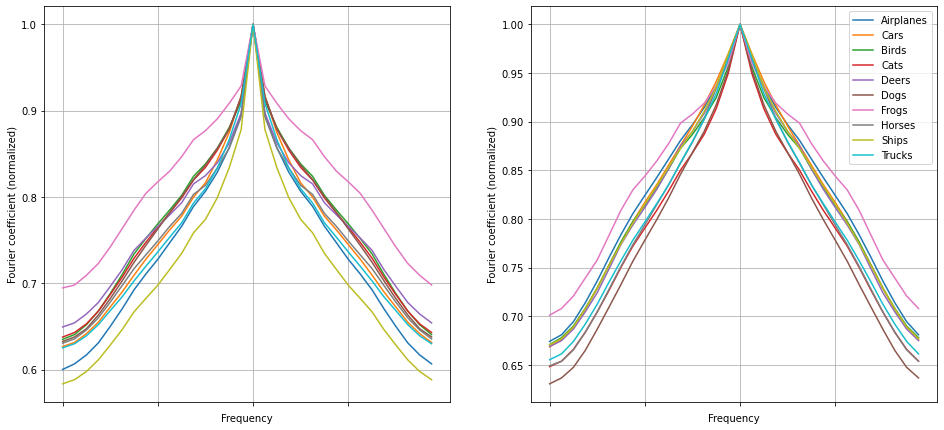

In [65]:
two_dim_0, zero_axis_0, one_axis_0, m_0, n_0,min_zero_axis_0,max_zero_axis_0, min_one_axis_0, max_one_axis_0, std_zero_axis_0, std_one_axis_0 = create_informations(subclass_0)
two_dim_1, zero_axis_1, one_axis_1, m_1, n_1,min_zero_axis_1,max_zero_axis_1, min_one_axis_1, max_one_axis_1, std_zero_axis_1, std_one_axis_1 = create_informations(subclass_1)
two_dim_2, zero_axis_2, one_axis_2, m_2, n_2,min_zero_axis_2,max_zero_axis_2, min_one_axis_2, max_one_axis_2, std_zero_axis_2, std_one_axis_2 = create_informations(subclass_2)
two_dim_3, zero_axis_3, one_axis_3, m_3, n_3,min_zero_axis_3,max_zero_axis_3, min_one_axis_3, max_one_axis_3, std_zero_axis_3, std_one_axis_3 = create_informations(subclass_3)
two_dim_4, zero_axis_4, one_axis_4, m_4, n_4,min_zero_axis_4,max_zero_axis_4, min_one_axis_4, max_one_axis_4, std_zero_axis_4, std_one_axis_4 = create_informations(subclass_4)
two_dim_5, zero_axis_5, one_axis_5, m_5, n_5,min_zero_axis_5,max_zero_axis_5, min_one_axis_5, max_one_axis_5, std_zero_axis_5, std_one_axis_5 = create_informations(subclass_5)
two_dim_6, zero_axis_6, one_axis_6, m_6, n_6,min_zero_axis_6,max_zero_axis_6, min_one_axis_6, max_one_axis_6, std_zero_axis_6, std_one_axis_6 = create_informations(subclass_6)
two_dim_7, zero_axis_7, one_axis_7, m_7, n_7,min_zero_axis_7,max_zero_axis_7, min_one_axis_7, max_one_axis_7, std_zero_axis_7, std_one_axis_7 = create_informations(subclass_7)
two_dim_8, zero_axis_8, one_axis_8, m_8, n_8,min_zero_axis_8,max_zero_axis_8, min_one_axis_8, max_one_axis_8, std_zero_axis_8, std_one_axis_8 = create_informations(subclass_8)
two_dim_9, zero_axis_9, one_axis_9, m_9, n_9,min_zero_axis_9,max_zero_axis_9, min_one_axis_9, max_one_axis_9, std_zero_axis_9, std_one_axis_9 = create_informations(subclass_9)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_0)),zero_axis_0/zero_axis_0.max(), label='Airplanes')
ax1.plot(range(len(zero_axis_1)),zero_axis_1/zero_axis_1.max(), label='Cars')
ax1.plot(range(len(zero_axis_2)),zero_axis_2/zero_axis_2.max(), label='Birds')
ax1.plot(range(len(zero_axis_3)),zero_axis_3/zero_axis_3.max(), label='Cats')
ax1.plot(range(len(zero_axis_4)),zero_axis_4/zero_axis_4.max(), label='Deers')
ax1.plot(range(len(zero_axis_5)),zero_axis_5/zero_axis_5.max(), label='Dogs')
ax1.plot(range(len(zero_axis_6)),zero_axis_6/zero_axis_6.max(), label='Frogs')
ax1.plot(range(len(zero_axis_7)),zero_axis_7/zero_axis_7.max(), label='Horses')
ax1.plot(range(len(zero_axis_8)),zero_axis_8/zero_axis_8.max(), label='Ships')
ax1.plot(range(len(zero_axis_9)),zero_axis_9/zero_axis_9.max(), label='Trucks')


ax2.plot(range(len(one_axis_0)),one_axis_0/one_axis_0.max(), label='Airplanes')
ax2.plot(range(len(one_axis_1)),one_axis_1/one_axis_1.max(), label='Cars')
ax2.plot(range(len(one_axis_2)),one_axis_2/one_axis_2.max(), label='Birds')
ax2.plot(range(len(one_axis_3)),one_axis_3/one_axis_3.max(), label='Cats')
ax2.plot(range(len(one_axis_4)),one_axis_4/one_axis_4.max(), label='Deers')
ax2.plot(range(len(one_axis_5)),one_axis_5/one_axis_5.max(), label='Dogs')
ax2.plot(range(len(one_axis_6)),one_axis_6/one_axis_6.max(), label='Frogs')
ax2.plot(range(len(one_axis_7)),one_axis_7/one_axis_7.max(), label='Horses')
ax2.plot(range(len(one_axis_8)),one_axis_8/one_axis_8.max(), label='Ships')
ax2.plot(range(len(one_axis_9)),one_axis_9/one_axis_9.max(), label='Trucks')

ax1.grid()
ax2.grid()

ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax2.set_xlabel('Frequency')
ax1.set_xticklabels([])
ax2.set_xticklabels([])

#leg = ax1.legend()
leg = ax2.legend()

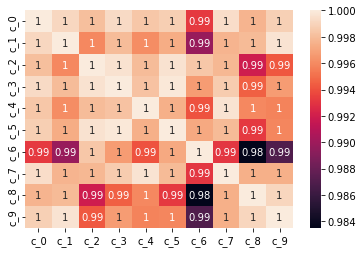

In [26]:
heat_data_zero = {
    'c_0': zero_axis_0,
    'c_1': zero_axis_1,
    'c_2': zero_axis_2,
    'c_3': zero_axis_3,
    'c_4': zero_axis_4,
    'c_5': zero_axis_5,
    'c_6': zero_axis_6,
    'c_7': zero_axis_7,
    'c_8': zero_axis_8,
    'c_9': zero_axis_9
}
df = pd.DataFrame(heat_data_zero,columns=['c_0','c_1','c_2','c_3','c_4','c_5','c_6','c_7','c_8','c_9'])

corrMatrix = df.corr()

sn.heatmap(corrMatrix, annot= True)
plt.show()



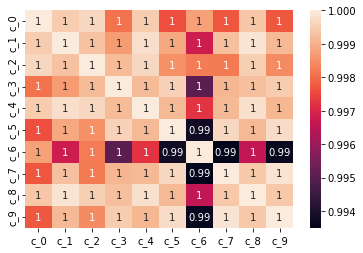

In [27]:
heat_data_one = {
    'c_0': one_axis_0,
    'c_1': one_axis_1,
    'c_2': one_axis_2,
    'c_3': one_axis_3,
    'c_4': one_axis_4,
    'c_5': one_axis_5,
    'c_6': one_axis_6,
    'c_7': one_axis_7,
    'c_8': one_axis_8,
    'c_9': one_axis_9
}
df = pd.DataFrame(heat_data_one,columns=['c_0','c_1','c_2','c_3','c_4','c_5','c_6','c_7','c_8','c_9'])

corrMatrix_one = df.corr()

sn.heatmap(corrMatrix_one, annot= True)
plt.show()


In [28]:
print(corrMatrix)
print('______________________________________________________________________')
print(corrMatrix_one)

          c_0       c_1       c_2       c_3       c_4       c_5       c_6  \
c_0  1.000000  0.999135  0.998068  0.999238  0.998444  0.998762  0.993215   
c_1  0.999135  1.000000  0.995930  0.997959  0.996105  0.997297  0.989784   
c_2  0.998068  0.995930  1.000000  0.999601  0.997960  0.999578  0.998440   
c_3  0.999238  0.997959  0.999601  1.000000  0.998204  0.999867  0.996682   
c_4  0.998444  0.996105  0.997960  0.998204  1.000000  0.997423  0.994014   
c_5  0.998762  0.997297  0.999578  0.999867  0.997423  1.000000  0.997181   
c_6  0.993215  0.989784  0.998440  0.996682  0.994014  0.997181  1.000000   
c_7  0.999379  0.997617  0.997803  0.998596  0.999622  0.997919  0.993076   
c_8  0.997677  0.997913  0.991906  0.994476  0.995930  0.993180  0.983499   
c_9  0.998790  0.999672  0.994233  0.996678  0.995708  0.995822  0.986972   

          c_7       c_8       c_9  
c_0  0.999379  0.997677  0.998790  
c_1  0.997617  0.997913  0.999672  
c_2  0.997803  0.991906  0.994233  
c_3  0.9

## Real 

In [29]:
list_real_classified = load_obj_real("/work/kabaeuer/data/cifar_realclassified")
len(list_real_classified)

49993

In [30]:
subclass_r_0 = []
subclass_r_1 = []
subclass_r_2 = []
subclass_r_3 = []
subclass_r_4 = []
subclass_r_5 = []
subclass_r_6 = []
subclass_r_7 = []
subclass_r_8 = []
subclass_r_9 = []

# create subclasses
for i in range(0,len(list_real_classified)):
    #print(list_real_classified[i])
    if list_real_classified[i] == 0:
        subclass_r_0.append(images_real[i])
    if list_real_classified[i] == 1:
        subclass_r_1.append(images_real[i])
    if list_real_classified[i] == 2:
        subclass_r_2.append(images_real[i])
    if list_real_classified[i] == 3:
        subclass_r_3.append(images_real[i])
    if list_real_classified[i] == 4:
        subclass_r_4.append(images_real[i])
    if list_real_classified[i] == 5:
        subclass_r_5.append(images_real[i])
    if list_real_classified[i] == 6:
        subclass_r_6.append(images_real[i])
    if list_real_classified[i] == 7:
        subclass_r_7.append(images_real[i])
    if list_real_classified[i] == 8:
        subclass_r_8.append(images_real[i])
    if list_real_classified[i] == 9:
        subclass_r_9.append(images_real[i])

In [31]:
print(len(subclass_r_0))
print(len(subclass_r_1))
print(len(subclass_r_2))
print(len(subclass_r_3))
print(len(subclass_r_4))
print(len(subclass_r_5))
print(len(subclass_r_6))
print(len(subclass_r_7))
print(len(subclass_r_8))
print(len(subclass_r_9))

5050
4993
4973
5420
4984
4728
4885
4991
5001
4968


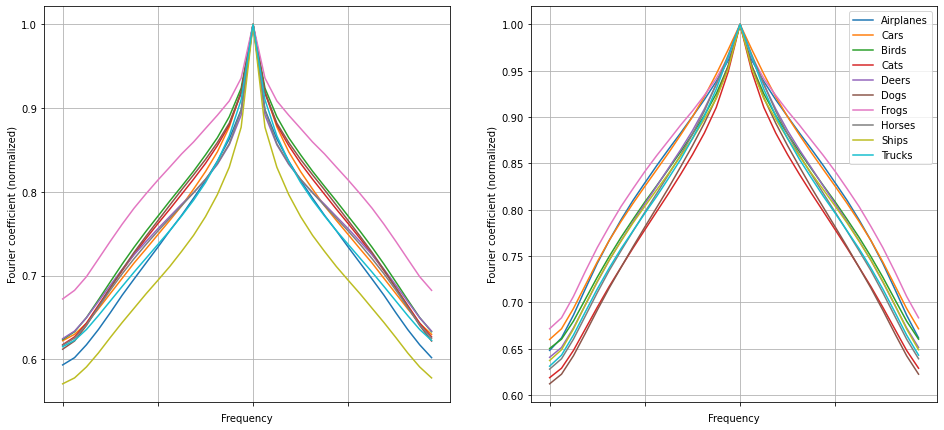

In [64]:
two_dim_r_0, zero_axis_r_0, one_axis_r_0, m_r_0, n_r_0,min_zero_axis_r_0,max_zero_axis_r_0, min_one_axis_r_0, max_one_axis_r_0, std_zero_axis_r_0, std_one_axis_r_0 = create_informations(subclass_r_0)
two_dim_r_1, zero_axis_r_1, one_axis_r_1, m_r_1, n_r_1,min_zero_axis_r_1,max_zero_axis_r_1, min_one_axis_r_1, max_one_axis_r_1, std_zero_axis_r_1, std_one_axis_r_1 = create_informations(subclass_r_1)
two_dim_r_2, zero_axis_r_2, one_axis_r_2, m_r_2, n_r_2,min_zero_axis_r_2,max_zero_axis_r_2, min_one_axis_r_2, max_one_axis_r_2, std_zero_axis_r_2, std_one_axis_r_2 = create_informations(subclass_r_2)
two_dim_r_3, zero_axis_r_3, one_axis_r_3, m_r_3, n_r_3,min_zero_axis_r_3,max_zero_axis_r_3, min_one_axis_r_3, max_one_axis_r_3, std_zero_axis_r_3, std_one_axis_r_3 = create_informations(subclass_r_3)
two_dim_r_4, zero_axis_r_4, one_axis_r_4, m_r_4, n_r_4,min_zero_axis_r_4,max_zero_axis_r_4, min_one_axis_r_4, max_one_axis_r_4, std_zero_axis_r_4, std_one_axis_r_4 = create_informations(subclass_r_4)
two_dim_r_5, zero_axis_r_5, one_axis_r_5, m_r_5, n_r_5,min_zero_axis_r_5,max_zero_axis_r_5, min_one_axis_r_5, max_one_axis_r_5, std_zero_axis_r_5, std_one_axis_r_5 = create_informations(subclass_r_5)
two_dim_r_6, zero_axis_r_6, one_axis_r_6, m_r_6, n_r_6,min_zero_axis_r_6,max_zero_axis_r_6, min_one_axis_r_6, max_one_axis_r_6, std_zero_axis_r_6, std_one_axis_r_6 = create_informations(subclass_r_6)
two_dim_r_7, zero_axis_r_7, one_axis_r_7, m_r_7, n_r_7,min_zero_axis_r_7,max_zero_axis_r_7, min_one_axis_r_7, max_one_axis_r_7, std_zero_axis_r_7, std_one_axis_r_7 = create_informations(subclass_r_7)
two_dim_r_8, zero_axis_r_8, one_axis_r_8, m_r_8, n_r_8,min_zero_axis_r_8,max_zero_axis_r_8, min_one_axis_r_8, max_one_axis_r_8, std_zero_axis_r_8, std_one_axis_r_8 = create_informations(subclass_r_8)
two_dim_r_9, zero_axis_r_9, one_axis_r_9, m_r_9, n_r_9,min_zero_axis_r_9,max_zero_axis_r_9, min_one_axis_r_9, max_one_axis_r_9, std_zero_axis_r_9, std_one_axis_r_9 = create_informations(subclass_r_9)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r_0)),zero_axis_r_0/zero_axis_r_0.max(), label='Airplanes')
ax1.plot(range(len(zero_axis_r_1)),zero_axis_r_1/zero_axis_r_1.max(), label='Cars')
ax1.plot(range(len(zero_axis_r_2)),zero_axis_r_2/zero_axis_r_2.max(), label='Birds')
ax1.plot(range(len(zero_axis_r_3)),zero_axis_r_3/zero_axis_r_3.max(), label='Cats')
ax1.plot(range(len(zero_axis_r_4)),zero_axis_r_4/zero_axis_r_4.max(), label='Deers')
ax1.plot(range(len(zero_axis_r_5)),zero_axis_r_5/zero_axis_r_5.max(), label='Dogs')
ax1.plot(range(len(zero_axis_r_6)),zero_axis_r_6/zero_axis_r_6.max(), label='Frogs')
ax1.plot(range(len(zero_axis_r_7)),zero_axis_r_7/zero_axis_r_7.max(), label='Horses')
ax1.plot(range(len(zero_axis_r_8)),zero_axis_r_8/zero_axis_r_8.max(), label='Ships')
ax1.plot(range(len(zero_axis_r_9)),zero_axis_r_9/zero_axis_r_9.max(), label='Trucks')


ax2.plot(range(len(one_axis_r_0)),one_axis_r_0/one_axis_r_0.max(), label='Airplanes')
ax2.plot(range(len(one_axis_r_1)),one_axis_r_1/one_axis_r_1.max(), label='Cars')
ax2.plot(range(len(one_axis_r_2)),one_axis_r_2/one_axis_r_2.max(), label='Birds')
ax2.plot(range(len(one_axis_r_3)),one_axis_r_3/one_axis_r_3.max(), label='Cats')
ax2.plot(range(len(one_axis_r_4)),one_axis_r_4/one_axis_r_4.max(), label='Deers')
ax2.plot(range(len(one_axis_r_5)),one_axis_r_5/one_axis_r_5.max(), label='Dogs')
ax2.plot(range(len(one_axis_r_6)),one_axis_r_6/one_axis_r_6.max(), label='Frogs')
ax2.plot(range(len(one_axis_r_7)),one_axis_r_7/one_axis_r_7.max(), label='Horses')
ax2.plot(range(len(one_axis_r_8)),one_axis_r_8/one_axis_r_8.max(), label='Ships')
ax2.plot(range(len(one_axis_r_9)),one_axis_r_9/one_axis_r_9.max(), label='Trucks')

ax1.grid()
ax2.grid()

ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax2.set_xlabel('Frequency')
ax1.set_xticklabels([])
ax2.set_xticklabels([])

#leg = ax1.legend()
leg = ax2.legend()
#fig.suptitle("Comparison between classes - real (Normalized) - left: colomn wise right: row-wise", fontsize=20)

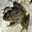

In [33]:
Image.fromarray(subclass_r_6[2])

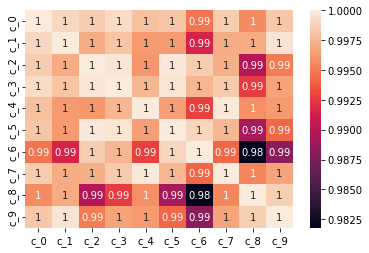

In [34]:
heat_data_r_zero = {
    'c_0': zero_axis_r_0,
    'c_1': zero_axis_r_1,
    'c_2': zero_axis_r_2,
    'c_3': zero_axis_r_3,
    'c_4': zero_axis_r_4,
    'c_5': zero_axis_r_5,
    'c_6': zero_axis_r_6,
    'c_7': zero_axis_r_7,
    'c_8': zero_axis_r_8,
    'c_9': zero_axis_r_9
}
df_r = pd.DataFrame(heat_data_r_zero,columns=['c_0','c_1','c_2','c_3','c_4','c_5','c_6','c_7','c_8','c_9'])

corrMatrix_r = df_r.corr()

sn.heatmap(corrMatrix_r, annot= True)
plt.show()

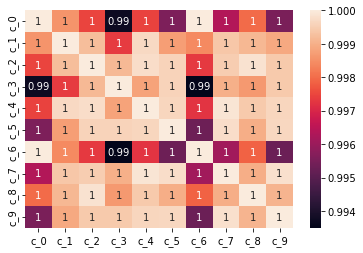

In [35]:
heat_data_r_one = {
    'c_0': one_axis_r_0,
    'c_1': one_axis_r_1,
    'c_2': one_axis_r_2,
    'c_3': one_axis_r_3,
    'c_4': one_axis_r_4,
    'c_5': one_axis_r_5,
    'c_6': one_axis_r_6,
    'c_7': one_axis_r_7,
    'c_8': one_axis_r_8,
    'c_9': one_axis_r_9
}
df_one_r = pd.DataFrame(heat_data_r_one,columns=['c_0','c_1','c_2','c_3','c_4','c_5','c_6','c_7','c_8','c_9'])

corrMatrix_one_r = df_one_r.corr()

sn.heatmap(corrMatrix_one_r, annot= True)
plt.show()


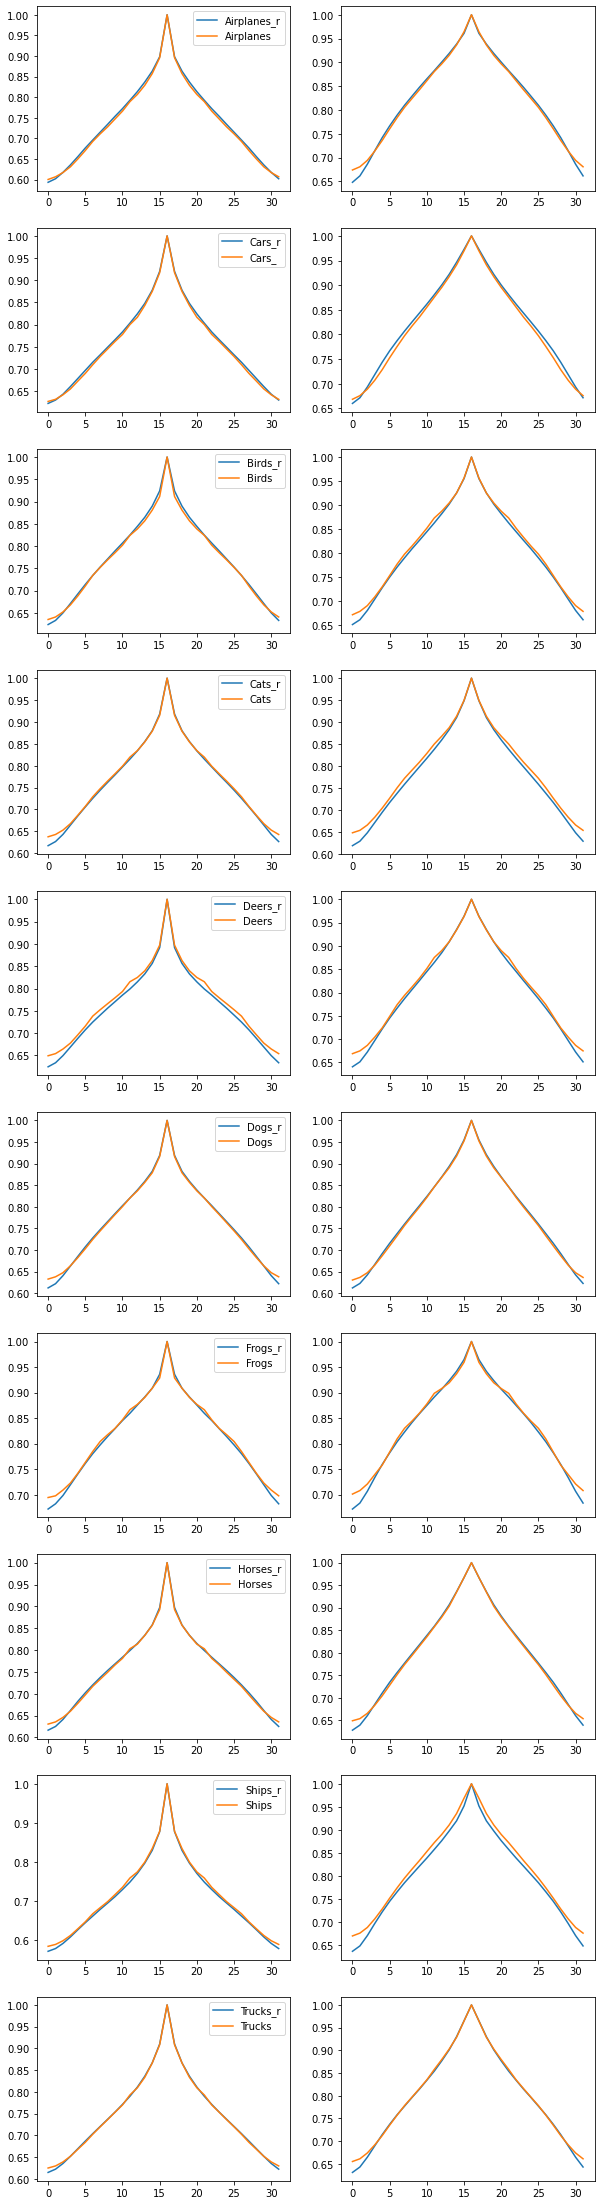

In [36]:
fig, ax = plt.subplots(10, 2)
fig.set_size_inches(10, 40)
ax1 = plt.subplot(10, 2, 1)
ax2 = plt.subplot(10, 2, 2)
ax3 = plt.subplot(10, 2, 3)
ax4 = plt.subplot(10, 2, 4)
ax5 = plt.subplot(10, 2, 5)
ax6 = plt.subplot(10, 2, 6)
ax7 = plt.subplot(10, 2, 7)
ax8 = plt.subplot(10, 2, 8)
ax9 = plt.subplot(10, 2, 9)
ax10 = plt.subplot(10, 2, 10)
ax11 = plt.subplot(10, 2, 11)
ax12 = plt.subplot(10, 2, 12)
ax13 = plt.subplot(10, 2, 13)
ax14 = plt.subplot(10, 2, 14)
ax15 = plt.subplot(10, 2, 15)
ax16 = plt.subplot(10, 2, 16)
ax17 = plt.subplot(10, 2, 17)
ax18 = plt.subplot(10, 2, 18)
ax19 = plt.subplot(10, 2, 19)
ax20 = plt.subplot(10, 2, 20)

ax1.plot(range(len(zero_axis_r_0)),zero_axis_r_0/zero_axis_r_0.max(), label='Airplanes_r')
ax1.plot(range(len(zero_axis_0)),zero_axis_0/zero_axis_0.max(), label='Airplanes')
ax2.plot(range(len(one_axis_r_0)),one_axis_r_0/one_axis_r_0.max(), label='Airplanes_r')
ax2.plot(range(len(one_axis_0)),one_axis_0/one_axis_0.max(), label='Airplanes_r')

ax3.plot(range(len(zero_axis_r_1)),zero_axis_r_1/zero_axis_r_1.max(), label='Cars_r')
ax3.plot(range(len(zero_axis_1)),zero_axis_1/zero_axis_1.max(), label='Cars_')
ax4.plot(range(len(one_axis_r_1)),one_axis_r_1/one_axis_r_1.max(), label='Cars_r')
ax4.plot(range(len(one_axis_1)),one_axis_1/one_axis_1.max(), label='Cars')

ax5.plot(range(len(zero_axis_r_2)),zero_axis_r_2/zero_axis_r_2.max(), label='Birds_r')
ax5.plot(range(len(zero_axis_2)),zero_axis_2/zero_axis_2.max(), label='Birds')
ax6.plot(range(len(one_axis_r_2)),one_axis_r_2/one_axis_r_2.max(), label='Birds_r')
ax6.plot(range(len(one_axis_2)),one_axis_2/one_axis_2.max(), label='Birds_2')

ax7.plot(range(len(zero_axis_r_3)),zero_axis_r_3/zero_axis_r_3.max(), label='Cats_r')
ax7.plot(range(len(zero_axis_3)),zero_axis_3/zero_axis_3.max(), label='Cats')
ax8.plot(range(len(one_axis_r_3)),one_axis_r_3/one_axis_r_3.max(), label='Cats_r')
ax8.plot(range(len(one_axis_3)),one_axis_3/one_axis_3.max(), label='Cats')

ax9.plot(range(len(zero_axis_r_4)),zero_axis_r_4/zero_axis_r_4.max(), label='Deers_r')
ax9.plot(range(len(zero_axis_4)),zero_axis_4/zero_axis_4.max(), label='Deers')
ax10.plot(range(len(one_axis_r_4)),one_axis_r_4/one_axis_r_4.max(), label='Deers_r')
ax10.plot(range(len(one_axis_4)),one_axis_4/one_axis_4.max(), label='Deers')

ax11.plot(range(len(zero_axis_r_5)),zero_axis_r_5/zero_axis_r_5.max(), label='Dogs_r')
ax11.plot(range(len(zero_axis_5)),zero_axis_5/zero_axis_5.max(), label='Dogs')
ax12.plot(range(len(one_axis_r_5)),one_axis_r_5/one_axis_r_5.max(), label='Dogs_r')
ax12.plot(range(len(one_axis_5)),one_axis_5/one_axis_5.max(), label='Dogs')

ax13.plot(range(len(zero_axis_r_6)),zero_axis_r_6/zero_axis_r_6.max(), label='Frogs_r')
ax13.plot(range(len(zero_axis_6)),zero_axis_6/zero_axis_6.max(), label='Frogs')
ax14.plot(range(len(one_axis_r_6)),one_axis_r_6/one_axis_r_6.max(), label='Frogs_r')
ax14.plot(range(len(one_axis_6)),one_axis_6/one_axis_6.max(), label='Frogs')

ax15.plot(range(len(zero_axis_r_7)),zero_axis_r_7/zero_axis_r_7.max(), label='Horses_r')
ax15.plot(range(len(zero_axis_7)),zero_axis_7/zero_axis_7.max(), label='Horses')
ax16.plot(range(len(one_axis_r_7)),one_axis_r_7/one_axis_r_7.max(), label='Horses_r')
ax16.plot(range(len(one_axis_7)),one_axis_7/one_axis_7.max(), label='Horses')

ax17.plot(range(len(zero_axis_r_8)),zero_axis_r_8/zero_axis_r_8.max(), label='Ships_r')
ax17.plot(range(len(zero_axis_8)),zero_axis_8/zero_axis_8.max(), label='Ships')
ax18.plot(range(len(one_axis_r_8)),one_axis_r_8/one_axis_r_8.max(), label='Ships_r')
ax18.plot(range(len(one_axis_8)),one_axis_8/one_axis_8.max(), label='Ships')


ax19.plot(range(len(zero_axis_r_9)),zero_axis_r_9/zero_axis_r_9.max(), label='Trucks_r')
ax19.plot(range(len(zero_axis_9)),zero_axis_9/zero_axis_9.max(), label='Trucks')
ax20.plot(range(len(one_axis_r_9)),one_axis_r_9/one_axis_r_9.max(), label='Trucks_r')
ax20.plot(range(len(one_axis_9)),one_axis_9/one_axis_9.max(), label='Trucks')


leg = ax1.legend()
leg = ax3.legend()
leg = ax5.legend()
leg = ax7.legend()
leg = ax9.legend()
leg = ax11.legend()
leg = ax13.legend()
leg = ax15.legend()
leg = ax17.legend()
leg = ax19.legend()